# QAOA - 3 noeuds

In [1]:
# Modules
from qiskit.quantum_info import Pauli, SparsePauliOp
from itertools import combinations
from qiskit import QuantumCircuit, transpile
import numpy as np
from scipy.optimize import minimize
from functools import reduce
from qiskit.circuit.library import PauliEvolutionGate
import pylatexenc
from qiskit_aer import Aer, AerSimulator  
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

il faut prendre cette contrainte en compte pour choisir les valeurs des variables: $g_i - d_i = \sum_{j, (i,j) \in L} l_{i,j}  =\sum_{j, (i,j)} l_{i,j}-\sum_{j,(j,i)}l_{j,i}$
 $,\forall i \in B$ 

In [2]:
# exemple de valeurs

q=3 #nombre de noeuds
P_i   = [5,10,0]        # puissance générée par le noeud  
c_i   = [15,5,0]       # coût par noeud
D_i   = [2,3,4]        # demande par noeud
D_tot=np.sum(D_i)

lam=100 #pénalité
P_ij={(0,1):6, (1,2): 6, (0,2):4} #flux entre deux noeuds

Puisque la taille du problème a augmenté en ajoutant un 3ème noeud, le nombre de qubits nécéssaires pour le calcul a également augmenté. Pour cela, on peut penser à éliminer les contraintes qui bornent les variables dans un premier temps, et voir ensuite les 5 premières solutions les plus probables et garder celle qui respecte les bornes.

In [3]:
liste = list(range(q))
couples = [(i, j) for i in range(q+1) for j in range(i, q+1)]


x_vars = [(i, j) for i in range(q) for j in range(i+1, q)]
beta_vars = [(i, m) for i in liste for m in range(9)] 

"""c_vars = [
    (i, s)
    for i in liste
    for s in range(int(np.ceil(np.log2(P_i[i])))
)
]"""


"""c_vars = []
for i in liste:
    if P_i[i] > 0:
        for s in range(int(np.ceil(np.log2(P_i[i])))):
            c_vars.append((i, s))
    else:
        c_vars.append((i, 0))  # cas si P_i[i] == 0


# c_vars2=[(i,j,p) for i in liste for j in range(i+1, q) for p in range(int(np.ceil(np.log2(P_ij[(i,j)]))))]
c_vars2=[]
for i in liste:
    for j in range(i+1, q):
        if abs(P_ij[(i,j)])>0: 
            for p in range(int(np.ceil(np.log2(abs(P_ij[(i,j)]))))): c_vars2.append((i,j,p))
            
        else: c_vars2.append((i,j,0))
        
        
#c_vars3= [(i,j,p) for i in liste for j in range(i+1, q) for p in range(int(np.ceil(np.log2(P_ij[(i,j)]))))]
c_vars3=[]
for i in liste:
    for j in range(i+1, q):
        if abs(P_ij[(i,j)])>0: 
            for p in range(int(np.ceil(np.log2(abs(P_ij[(i,j)]))))): c_vars3.append((i,j,p))
            
        else: c_vars3.append((i,j,0))"""
        
        
        
all = x_vars + beta_vars #+ c_vars + c_vars2+ c_vars3
qubit_index = {f"x_{i}_{j}": idx for idx, (i,j) in enumerate(x_vars)}
offset = len(x_vars)
for k, (i,m) in enumerate(beta_vars):
    qubit_index[f"beta_{i}_{m}"] = offset + k
    
"""offset = len(x_vars) + len(beta_vars)
for k, (i, s) in enumerate(c_vars):
    qubit_index[f"c_{i}_{s}"] = offset + k
    
offset=len(x_vars) + len(beta_vars)+ len(c_vars)
for k, (i,j,p) in enumerate (c_vars2):
    qubit_index[f"c2_{i}_{j}_{p}"]=offset+k
    
offset=len(x_vars) + len(beta_vars)+ len(c_vars)+ len(c_vars3)
for k, (i,j,p) in enumerate (c_vars3):
    qubit_index[f"c3_{i}_{j}_{p}"]=offset+k"""


n_qubit = len(all)

print("le nombre de qubits est:", n_qubit)

le nombre de qubits est: 30


In [4]:
#Pour coder les index
def idx_x(i, j):
    return qubit_index[f"x_{i}_{j}"]

def idx_beta(i, s, m):
    return qubit_index[f"beta_{i}_{m}"]

def idx_c(i,r):
    return qubit_index[f"c_{i}_{r}"]

def idx_c2(i,j,p):
    return qubit_index[f"c2_{i}_{j}_{p}"]

def idx_c3(i,j,p):
    return qubit_index[f"c3_{i}_{j}_{p}"]

## Hamiltonien de coût

In [5]:
terms = []
B_ij = {(0,1): 1.0, (1,2):1, (0,2):1 }

for i in range(q):
    for j in range(i+1, q):
        if (i,j) not in B_ij:
            continue
        Bij = B_ij[(i,j)]
        for m in range(5):  # M: nombre de "modes" alpha
            for s in range(m+1,5):  # S: nombre de bits pour l'encodage binaire
                coeff = (1 / 4.0) * (2**s) * (lam + c_i[i]) * Bij * np.pi/180

                x_idx = idx_x(i,j)
                b_i_idx = idx_beta(i,s,m)
                b_j_idx = idx_beta(j,s,m)

                # - Z_x * Z_beta_j
                pauli = ['I'] * n_qubit
                pauli[x_idx] = 'Z'
                pauli[b_j_idx] = 'Z'
                terms.append((''.join(pauli), -coeff))

                # + Z_x * Z_beta_i
                pauli = ['I'] * n_qubit
                pauli[x_idx] = 'Z'
                pauli[b_i_idx] = 'Z'
                terms.append((''.join(pauli), coeff))

                # + Z_beta_j
                pauli = ['I'] * n_qubit
                pauli[b_j_idx] = 'Z'
                terms.append((''.join(pauli), coeff))

                # - Z_beta_i
                pauli = ['I'] * n_qubit
                pauli[b_i_idx] = 'Z'
                terms.append((''.join(pauli), -coeff))


In [6]:
for i in range(q):
    for j in range(i+1, q):
        terms.append(('I'*n_qubit, -P_ij[(i,j)]+ 2 * D_i[i]-P_i[i] ))    

In [ ]:
'''for i in range(q):
    if(P_i[i]>0):
        ki=int(np.ceil(np.log2(P_i[i] )))
    else: ki=0
    for r in range(ki):
            c_idx = idx_c(i, r)  # mapping des qubits c_{r,i}
            coeff = 2**(r-1)

            # 1 * coeff (pour le "1" dans (1 - Z))
            terms.append(('I'*n_qubit, coeff))

            # -Z_c * coeff
            pauli = ['I'] * n_qubit
            pauli[c_idx] = 'Z'
            terms.append((''.join(pauli), -coeff))'''


In [ ]:
'''for i in range(q):
    
    for j in range(i+1,q):
        kij=int(np.ceil(np.log2(abs(P_ij[(i,j)]))))

        for p in range(kij):
            c2_idx = idx_c2(i,j, p)  
            coeff = 2**(p-1)

            # 1 * coeff (pour le "1" dans (1 - Z))
            terms.append(('I'*n_qubit, coeff))

            # -Z_c * coeff
            pauli = ['I'] * n_qubit
            pauli[c2_idx] = 'Z'
            terms.append((''.join(pauli), -coeff))'''

In [ ]:
'''for i in range(q):
    
    for j in range(i+1,q):
        kij=int(np.ceil(np.log2(abs(P_ij[(i,j)]))))

        for p in range(kij):
            c3_idx = idx_c3(i,j, p)  
            coeff = 2**(p-1)

            terms.append(('I'*n_qubit, coeff))

            pauli = ['I'] * n_qubit
            pauli[c3_idx] = 'Z'
            terms.append((''.join(pauli), -coeff))'''

In [7]:
H_c = SparsePauliOp.from_list(terms)

## Hamiltonien de mélange

In [8]:
H_M = SparsePauliOp.from_list([
    ('I'*i + 'X' + 'I'*(n_qubit-i-1), 1.0)
    for i in range(n_qubit)
])

print(H_M)


SparsePauliOp(['XIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IXIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIXIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIXIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIXIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIXIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIXIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIXIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIXIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIXIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIXIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIXIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIXIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIXIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIXIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIXIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIXIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIXIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIXIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIXIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIXIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIXIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIXIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIXIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIXIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIXIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIXIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIXII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIXI',

## Les opérateurs d'évolution temporelle

In [9]:
def U_C(gamma, H):
    gate = PauliEvolutionGate(H, time=gamma)
    return gate.definition  

def U_M(beta, H):
    gate = PauliEvolutionGate(H, time=beta)
    return gate.definition


## Construction du circuit QAOA 

In [10]:

def build_qaoa_circuit(n, p, gammas, betas, cost_h, mixer_h):
    qc = QuantumCircuit(n)  
    qc.h(range(n))          
    
    for layer in range(p):
        qc.append(U_C(float(gammas[layer]), cost_h), range(n))
        qc.append(U_M(float(betas[layer]), mixer_h), range(n))
    
    return qc 


### Exemple du circuit QAOA 

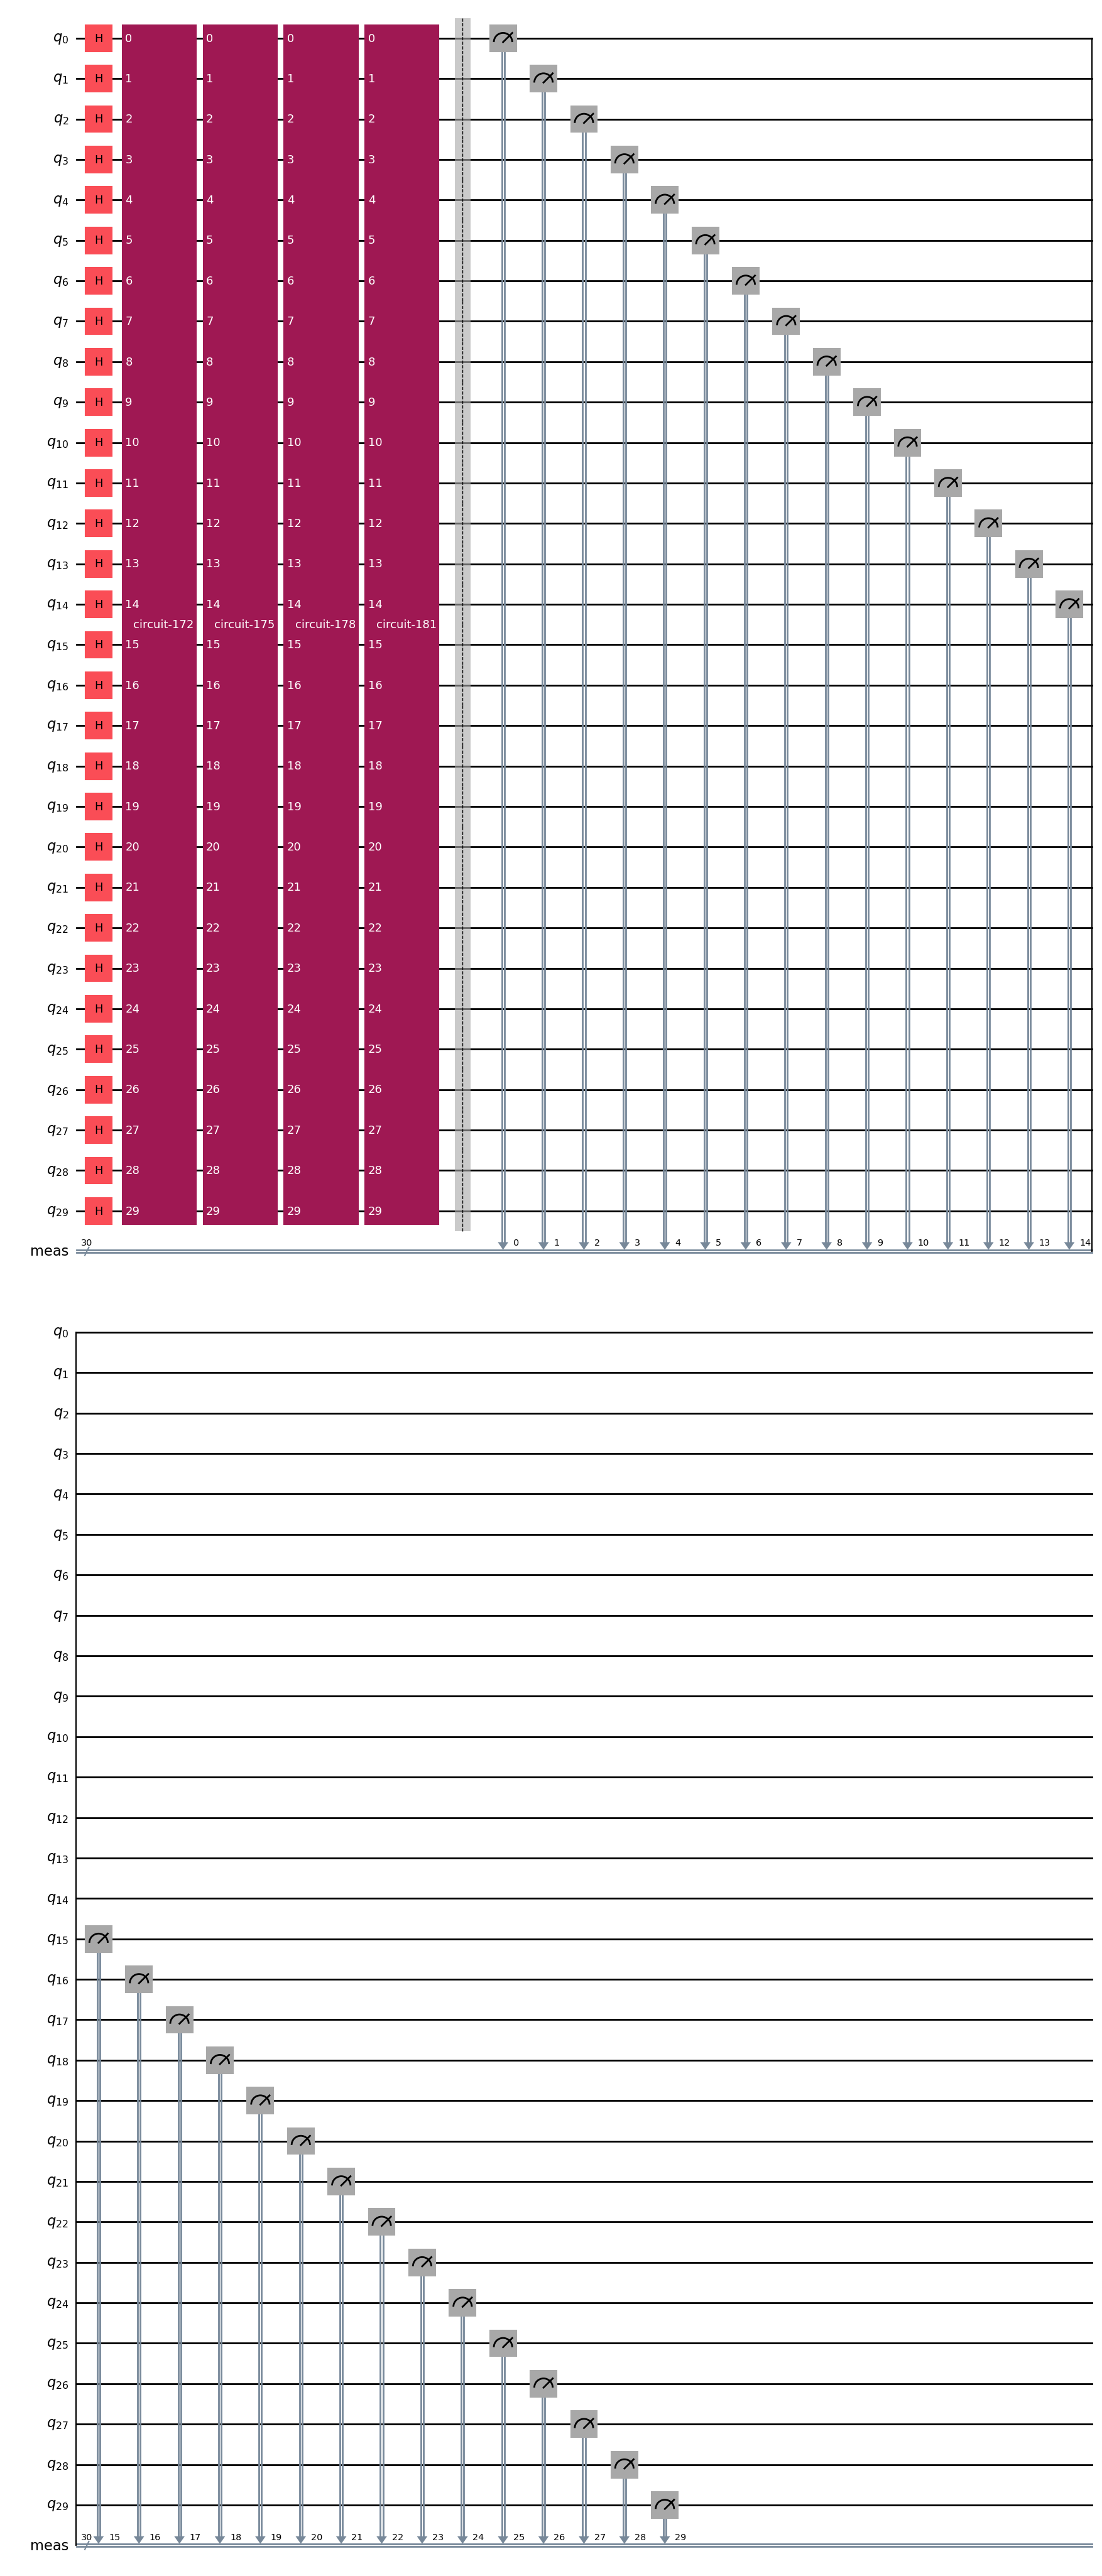

In [11]:
p=2 # nombre de couches
g=[np.pi/4, np.pi/2, np.pi/6, np.pi/7, np.pi/10]
gammas=g[:p]
b=[np.pi/8, np.pi/4, np.pi/3, np.pi/8, np.pi/2]
betas=b[:p]
params = gammas + betas

cost_h=H_c
mixer_h=H_M
qc2=build_qaoa_circuit(n_qubit,p,gammas,betas,cost_h,mixer_h)
qc2.measure_all()
qc2.draw("mpl")


# Affichage du résultat très long --> Plusieurs valeurs

### Exemple de mesure (sans optimisation)

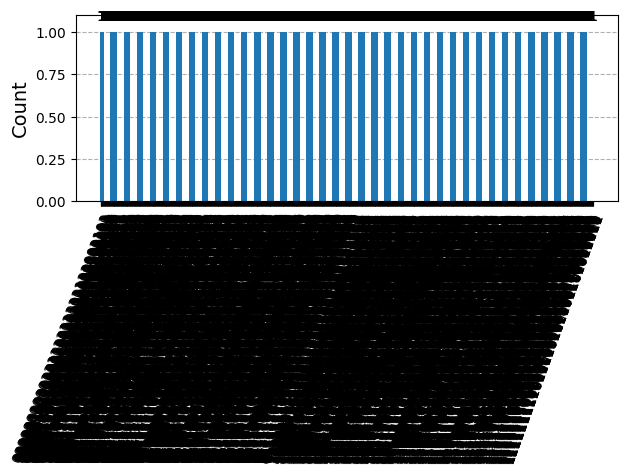

In [12]:
#la mesure
qc_transpiled2 = transpile(qc2, AerSimulator())

job = AerSimulator().run(qc_transpiled2, shots=1024)
result = job.result()
counts = result.get_counts()

plot_histogram(counts)


In [13]:
from qiskit_aer import AerSimulator
sim = AerSimulator()
print(sim.available_devices())


('CPU',)


### utilisation de qasm simulator

In [ ]:
from qiskit import transpile
from qiskit.visualization import plot_histogram

# Transpilation pour le simulateur
qc_transpiled = transpile(qc2, Aer.get_backend('qasm_simulator'))

# Exécution
simulator = Aer.get_backend('qasm_simulator')
job = simulator.run(qc_transpiled, shots=1024)
result = job.result()

# Récupération des mesures
counts = result.get_counts()

# Affichage
plot_histogram(counts)


### utilisation de qisikit.quantuminfo simulator

In [ ]:
from qiskit.quantum_info import Statevector

# Récupération du statevector directement depuis le circuit
statevector = Statevector.from_instruction(qc2)

# Conversion en probabilités
counts = statevector.probabilities_dict()

plot_histogram(counts)


## Définition de la fonction objectif

In [14]:
from qiskit import transpile
from qiskit_aer import Aer
import numpy as np
from scipy.optimize import minimize

backend = Aer.get_backend('aer_simulator')

def qaoa_expectation(params):
    gammas = params[:p]
    betas = params[p:]
    
    qc2 = build_qaoa_circuit(n_qubit, p, gammas, betas, H_c, H_M)
    qc2.save_statevector()
    
    qc_transpiled = transpile(qc2, backend)
    result = backend.run(qc_transpiled).result()
    
    sv = result.data(0)['statevector']
    expval = sv.expectation_value(H_c)
    return np.real(expval) 




## Optimisation --> Garder les 5 premières solutions

In [ ]:
import time

p=4
g=[np.pi/4, np.pi/2, np.pi/6, np.pi/7, np.pi/10]
gammas=g[:p]
b=[np.pi/8, np.pi/4, np.pi/3, np.pi/8, np.pi/2]
betas=b[:p]
params = gammas + betas # à changer par concatenation !!
start = time.time()

#mesure
result = minimize(qaoa_expectation, params, method='COBYLA')

print("Paramètres optimaux :", result.x)
print("Espérance d'énergie minimale :", -result.fun)

# Circuit avec les paramètres optimaux

gammas=result.x[:p]
betas=result.x[p:]

qc3 = build_qaoa_circuit(n_qubit,p, gammas,betas,cost_h,mixer_h)
qc3.measure_all()
qc_transpiled3 = transpile(qc3, AerSimulator())

job = AerSimulator().run(qc_transpiled3, shots=1024)
result_new = job.result()
counts_new = result_new.get_counts()


end = time.time()
print("Temps d'exécution :", end - start, "secondes")



In [ ]:
import os
# Trier les bitstrings par nombre d’occurrences décroissant
top_5 = sorted(counts_new.items(), key=lambda item: item[1], reverse=True)[:5]

with open("resultats_qaoa.txt", "w", encoding="utf-8") as f:
    f.write("Top 5 des bitstrings les plus probables :\n")
    
    for bitstring, count in top_5:
        f.write(f"{bitstring} → {count} fois\n")
        
        inv_index = {v: k for k, v in qubit_index.items()}  # j’inverse le dict

        bit_values = {}
        for i, bit in enumerate(reversed(bitstring)):
            var_name = inv_index[i]
            bit_values[var_name] = int(bit)

        x_values = {k: v for k, v in bit_values.items() if k.startswith("x_")}
        beta_values = {k: v for k, v in bit_values.items() if k.startswith("beta_")}

        for var_group, values in [("x_vars", x_values), ("beta_vars", beta_values)]:
            f.write(f"{var_group}:\n")
            for var, val in sorted(values.items()):
                f.write(f"  {var} = {val}\n")
                
        for var_group, values in [("beta_vars", beta_values)]:
            f.write(f"{var_group}:")

    # Séparer selon le deuxième champ cad : beta_0_i ou beta_1_i
    
        half0 = {k: v for k, v in values.items() if k.startswith("beta_0_")}
        half1 = {k: v for k, v in values.items() if k.startswith("beta_1_")}
        for label, group in [("beta_0", half0), ("beta_1", half1)]:
                total = 0
                for var, val in sorted(group.items(), key=lambda x: int(x[0].split("_")[-1])):
                    bit_pos = int(var.split("_")[-1])
                    contrib = val * (2 ** bit_pos)
                    total += contrib
        f.write(f"    --> Donc: theta = {total}\n")

        
        f.write("Autre possibilité:\n\n")
        

with open("resultats_qaoa.txt", "r", encoding="utf_8") as f:
    print(f.read())
    
os.system("resultats_qaoa.txt")
